# Cleaner version of embedding and fMRI
Using the Utility functions in utility.py

Here we grab neuroimaging of people during recall of an event (trauma, mundane, rumination). Next we embed (using word2vec) 300 feature vector for each word of their recall text.
Last, we fit Ridge Regression using split (1st vs. 2nd half) cross validation for each subject, under each condition (trauma/rumination or mundane). 
Lastly, we save this file to further analyise in a different script

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utility import *

from nilearn.plotting import plot_stat_map

In [99]:
subject_list = ['1237','1384','1547','1599','1629','1640','1654','1655','1659',
'1663','1674','1676','1681','1682','1684', '1685','1686','1691','1700','1703']

task_list = ['trauma','healthy','mundane']

In [539]:
sub = '1703'
task_n = 'trauma' # for neuroimage file
task_t = 'healthy' # for text file
func_file = f'../Downloads/prePost/{task_n}/sub-{sub}_ses-1_denoise_smooth6mm_task-{task_n}recall_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
text_file = f'text/sub-{sub}_{task_t}.txt'

In [540]:
# extract timeseries
masker, func_parcels = extractNeuro(func_file)

In [541]:
func_parcels.shape[0]

305

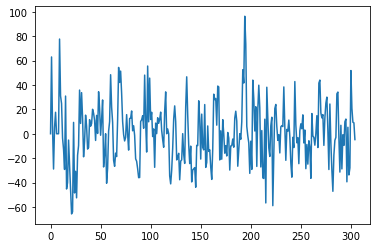

In [542]:
plt.plot(func_parcels[:,50])

In [543]:
Y_parcels = func_parcels[3:-3] # cut some TRs
Y_parcels.shape

(299, 400)

In [544]:
transcript_w2v = readText(text_file)

In [545]:
X_w2v = construct_predictors(transcript_w2v, 300, Y_parcels.shape[0], tr=1)

<Axes: >

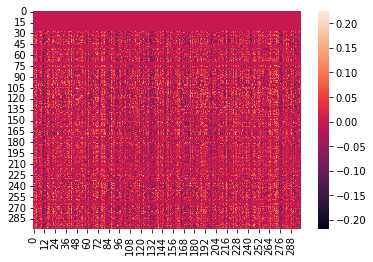

In [546]:
sns.heatmap(X_w2v)

In [547]:
Y_predicted = runRidgeReg(X_w2v,Y_parcels)

In [548]:
from himalaya.scoring import correlation_score

# Evaluate predictions: correlation between predicted and actual time series
score_parcels = correlation_score(Y_parcels, Y_predicted)

print(f"Mean encoding performance: r = {np.mean(score_parcels):.3f}")
print(f"Maximum encoding performance: r = {np.amax(score_parcels):.3f}")

Mean encoding performance: r = -0.000
Maximum encoding performance: r = 0.191


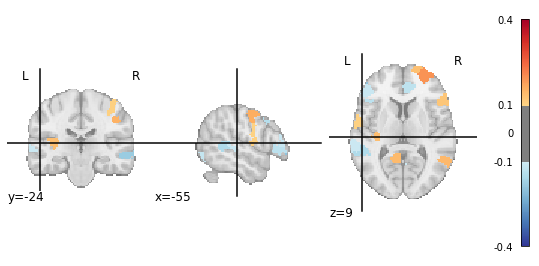

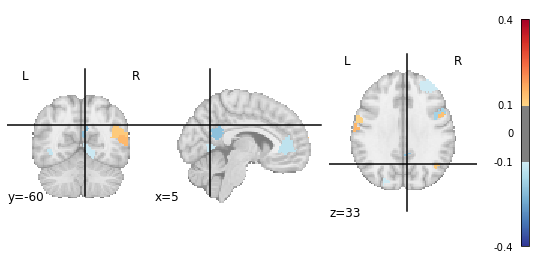

In [549]:
# Invert masker transform to project onto brain
score_img = masker.inverse_transform(score_parcels)
# Plot encoding performance correlations on brain
vmax = .4
threshold = .1
plot_stat_map(score_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(score_img, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(5, -60, 33));

In [550]:
# save
score_img.to_filename(f'betaFiles/sub-{sub}_ridge_{task_t}.nii.gz')